In [22]:
import pandas as pd
import quandl
import math , datetime, time
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from sklearn import preprocessing, cross_validation, svm 
from sklearn.linear_model import LinearRegression
import pickle
style.use('ggplot')

## Alright let's begin 

This Jupyter notebook helps predict the stock prices one month in advance! 

In [5]:
# figure out a best fit line
stockticker  = 'WIKI/GOOGL'
df = quandl.get(stockticker)

# features available
# 'Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']

#grab relavent features
df = df[['Adj. Open', 'Adj. High','Adj. Low', 'Adj. Close', 'Adj. Volume',]]

# Make new coloumn High - Low %
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100

# Make new coloumn Close - Open %
df['PCT_change'] = ( df['Adj. Close'] - df['Adj. Open'])/ df['Adj. Open'] * 100

# Choose more relavent updated features
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

# Create coloumn for future prediction
forecast_col = 'Adj. Close'

# treats as outlier if data not present; inplace allows to edit there itself 
df.fillna(-99999, inplace=True)

#predict 1% of the len(dataframe) out into future
forecast_out = int(math.ceil(0.01 * len(df)))

#forecast the Adj. Close price 10% length into the future to train
df['label'] = df[forecast_col].shift(-forecast_out)

print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.441017    0.324968   44659000.0  67.739104
2004-08-20   54.322689  8.537313    7.227007   22834300.0  69.399229
2004-08-23   54.869377  4.062357   -1.227880   18256100.0  68.752232
2004-08-24   52.597363  7.753210   -5.726357   15247300.0  69.639972
2004-08-25   53.164113  3.966115    1.183658    9188600.0  69.078238


In [75]:
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume  label
Date                                                            
2016-09-02      796.87  0.484078    0.201190    1346589.0    NaN
2016-09-06      808.02  1.943603    1.206177    1963804.0    NaN
2016-09-07      807.99  0.856020    0.007426    1144517.0    NaN
2016-09-08      802.84  0.925069   -0.295571    1132390.0    NaN
2016-09-09      788.48  1.738468   -1.288231    1835378.0    NaN


In [6]:
# TO TRAIN
# select features (INPUTS)
# df.drop returns new array without label; 1 signifies droppping coloumn
X = np.array((df.drop(['label'],1)))

# SCALE
#X = preprocessing.scale(X)

# Consider only Xs that have Ys ie upto len(df) - forecast_out
# Last 30 days without y values 
X_lately = X[-forecast_out: ]
X = X[:-forecast_out]


df.dropna(inplace=True)

# TARGET to train against (y)
y = np.array(df['label'])

print(len(X), len(y))

(3006, 3006)


In [24]:
# SPLIT the data to training and testing data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

# Classifier is LINEAR REGRESSION
# thread to run max no of jobs 
clf = LinearRegression(n_jobs = -1)

# TRAIN!
clf.fit(X_train, y_train)

with open('linearregression.pickle','wb') as f:
    pickle.dump( clf, f)

pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

# TEST!
accuracy = clf.score(X_test, y_test)

print(accuracy)


0.966898936197


In [25]:
forecast_set = clf.predict(X_lately)
#important
print(forecast_set, accuracy, forecast_out)

(array([ 773.0012641 ,  797.34759197,  805.77475213,  807.8202184 ,
        807.00737507,  805.60082866,  814.30881941,  813.52679284,
        815.04569843,  817.040553  ,  816.20307202,  815.72818191,
        814.15462634,  809.40501275,  813.10533727,  811.16307994,
        808.23696826,  805.58851753,  805.26067299,  801.74660254,
        799.45768566,  800.93953527,  803.90212538,  799.93870336,
        798.3532098 ,  799.6610681 ,  805.43360497,  814.36349071,
        816.13068356,  811.00144763,  795.7410742 ]), 0.96689893619676648, 31)


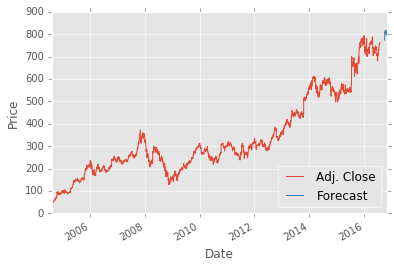

In [26]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = time.mktime(last_date.timetuple())
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range( len(df.columns) -1 )] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()